**Modules and other necessary inclusions to the notebook**

In [ ]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

**Necessary classes**

City class to generate a new city in X and Y co-ordinates and methods related to a city

In [ ]:
class City:
  
  # Defining a city as a 2d point
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  # Defining a method to return distance between our city and a given city
  def distance(self, city):
    xCor = abs(self.x - city.x)
    yCor = abs(self.y - city.y)
    dist = np.sqrt(xCor ** 2 + yCor ** 2)
    return dist

  # Defining the representationof a city
  def __repr__(self):
    return "(" + str(self.x) + "," + str(self.y) + ")"  

**Necessary Functions**


Fitness function of a given route

In [ ]:
# Fitness Function = 1/(Total Distance of the path)
def fitness_func(route):
  fitness_value = 0
  for i in range(len(route)-1):
    fitness_value += route[i].distance(route[i+1])
  return 1/fitness_value

Random Generation of a path using a list of cities

In [ ]:
def generate_path(citylist):
  return random.sample(citylist, len(citylist))

**Plot of all the cities involved**

In [ ]:
def plot_cities(citylist, title, line=False):
    X = np.array([c.x for c in citylist])
    y = np.array([c.y for c in citylist])
    if line:
        plt.plot(X, y, '-o')
    else:
        plt.scatter(X, y)
    plt.title(title)

# **GENETIC ALGORITHM**

## 1. Initialisation

Creating a population

In [ ]:
#Creating distinct routes to avoid duplicate values in the initial population
def starting_population(citylist, size_of_population):
  population = []
  while len(population) < size_of_population:
    new_route = generate_path(citylist)
    population.append(new_route)
  return population

Determining the fitness value of every route in the population and sorting them based on the best fitness values

In [ ]:
def ordered_routes(population):
  #Creating a dictionary to store the route number as a key and the fitness associated with it as the value
  fitness_values = {}
  for i in range(len(population)):
    fitness_values[i] = fitness_func(population[i])
  return sorted(fitness_values.items(), key = operator.itemgetter(1), reverse = True)   # Returning the sorted dictionary sorted based on values and not key

## 2. Selection

Parent selection is usually done in 2 ways, Roulette Wheel Selection and Tournament based Selection and we are implementing Elitism to check for Survivor Selection as it is the optimized method

### (a) Roulette Wheel Selection

In [ ]:
def rw_selection(ranked_population, elite_size):
  
  selection_results = []
  df = pd.DataFrame(np.array(ranked_population), columns = ['Index', 'Fitness'])
  df['Cum_Sum'] = df.Fitness.cumsum()
  df['Cum_Perc'] = 100*df.Cum_Sum/df.Fitness.sum()

  for i in range(0, elite_size):
      selection_results.append(ranked_population[i][0])
  for i in range(0, len(ranked_population) - elite_size):
      pick = 100*random.random()
      for i in range(0, len(ranked_population)):
          if pick <= df.iat[i,3]:
              selection_results.append(ranked_population[i][0])
              break
  
  return selection_results

### (b) Tournament based selection

In [ ]:
def tm_selection(ranked_population, elite_size, tournament_size):
  
  selection_results = []
  
  for i in range(0, elite_size):
    selection_results.append(ranked_population[i][0])
  
  for i in range(0, len(ranked_population) - elite_size):
    competors = random.sample(ranked_population, tournament_size)
    winner = competors[0]
    for j in range(tournament_size):
      if winner[1] < competors[j][1]:
        winner = competors[j]
    selection_results.append(winner[0])
  
  return selection_results

### Defining the mating pool from the members selected based on fitness

In [ ]:
def mating_pool(population, selection_results):
    mating_pool = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        mating_pool.append(population[index])
    return mating_pool

## 3.Crossover

There are 3 popular Crossover techniques, they are the 1-point Crossover, 2-point Crossover and Uniform Crossover but I will be using One Point crossover

In [ ]:
def one_point_breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

def op_breed_population(mating_pool, elite_size):
    
    children = []
    
    length = len(mating_pool) - elite_size
    pool = random.sample(mating_pool, len(mating_pool))

    for i in range(0,elite_size):
        children.append(mating_pool[i])
    
    for i in range(0, length):
        child = one_point_breed(pool[i], pool[len(mating_pool)-i-1])
        children.append(child)
    return children

## 4. Mutation

We perform mutation on the individual paths in the population by swapping two random cities in path with a small probability to generate diversity in the sample

In [ ]:
def mutate(population_instance, mutation_rate):
    for swapped in range(len(population_instance)):
        if(random.random() < mutation_rate):
            swapWith = int(random.random() * len(population_instance))
            
            city1 = population_instance[swapped]
            city2 = population_instance[swapWith]
            
            population_instance[swapped] = city2
            population_instance[swapWith] = city1
    return population_instance


def mutate_population(population, mutation_rate):
    mutated_population = []
    
    for ind in range(len(population)):
        mutated_individual = mutate(population[ind], mutation_rate)
        mutated_population.append(mutated_individual)
    return mutated_population

## 5. Repeat

This is the part where we use all the above functions to generate a new generation from an existing one

In [ ]:
def rw_next_generation(current_gen, elite_size, mutation_rate):
  ranked_population = ordered_routes(current_gen)
  rw_sel_results = rw_selection(ranked_population, elite_size)
  rw_mating = mating_pool(current_gen, rw_sel_results)
  rw_children = op_breed_population(rw_mating, elite_size)
  rw_next_gen = mutate_population(rw_children, mutation_rate)
  return rw_next_gen

def tm_next_generation(current_gen, elite_size, mutation_rate, tournament_size):
  ranked_population = ordered_routes(current_gen)
  tm_sel_results = tm_selection(ranked_population, elite_size, tournament_size)
  tm_mating = mating_pool(current_gen, tm_sel_results)
  tm_children = op_breed_population(tm_mating, elite_size)
  tm_next_gen = mutate_population(tm_children, mutation_rate)
  return tm_next_gen

## 6. Evolution

In [ ]:
def rw_genetic_algo(population, elite_size, mutation_rate, no_of_generation):
    
    print("Initial distance: " + str(1 / ordered_routes(population)[0][1]))
    
    for i in range(0, no_of_generation):
        population = rw_next_generation(population, elite_size, mutation_rate)
    
    print("Final distance Roulette based: " + str(1 / ordered_routes(population)[0][1]))
    best_index = ordered_routes(population)[0][0]
    best_route = population[best_index]
    return best_route

In [ ]:
def tm_genetic_algo(population, elite_size, mutation_rate, no_of_generation, tournament_size):

    print("Initial distance: " + str(1 / ordered_routes(population)[0][1]))
    
    for i in range(0, no_of_generation):
        population = tm_next_generation(population, elite_size, mutation_rate, tournament_size)
    
    print("Final distance Tournament based: " + str(1 / ordered_routes(population)[0][1]))
    best_index = ordered_routes(population)[0][0]
    best_route = population[best_index]
    return best_route

# **Main Function**

In [ ]:
citylist = []

for i in range(0,25):
    citylist.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

print("Cities : ", citylist)

population = starting_population(citylist, size_of_population=100)

rw_best_route = rw_genetic_algo(population, elite_size=20, mutation_rate=0.01, no_of_generation=500)
tm_best_route = tm_genetic_algo(population, elite_size=20, mutation_rate=0.01, no_of_generation=500, tournament_size = 3)

print("Roulette Wheel best route : ",rw_best_route)
print("Tournament based best route : ",tm_best_route)

Cities :  [(83,77), (77,103), (94,77), (124,101), (106,188), (73,97), (88,18), (67,42), (73,199), (175,111), (150,172), (158,112), (193,93), (189,14), (77,112), (173,119), (131,15), (98,116), (2,114), (73,61), (191,124), (104,44), (37,52), (175,167), (154,92)]
Initial distance: 1892.6971575691796
Final distance Roulette based: 886.0574895930963
Initial distance: 1892.6971575691796
Final distance Tournament based: 852.2696012295393
Roulette Wheel best route :  [(154,92), (124,101), (77,112), (98,116), (94,77), (73,61), (67,42), (37,52), (2,114), (73,97), (77,103), (83,77), (104,44), (88,18), (131,15), (189,14), (193,93), (173,119), (158,112), (175,111), (191,124), (175,167), (150,172), (106,188), (73,199)]
Tournament based best route :  [(175,167), (150,172), (106,188), (73,199), (2,114), (77,112), (77,103), (73,97), (94,77), (104,44), (88,18), (131,15), (189,14), (193,93), (191,124), (173,119), (175,111), (158,112), (154,92), (124,101), (98,116), (83,77), (73,61), (67,42), (37,52)]


# **Plots**

In [ ]:
def geneticAlgorithmPlot(citylist, size_of_population, elite_size, mutation_rate, no_of_generation, tournament_size):
    population = starting_population(citylist, size_of_population)
    rw_progress = []
    tm_progress = []
    rw_progress.append(1 / ordered_routes(population)[0][1])
    tm_progress.append(1 / ordered_routes(population)[0][1])
    
    for i in range(0, no_of_generation):
        population = rw_next_generation(population, elite_size, mutation_rate)
        rw_progress.append(1 / ordered_routes(population)[0][1])

    for i in range(0, no_of_generation):
        population = tm_next_generation(population, elite_size, mutation_rate, tournament_size)
        tm_progress.append(1 / ordered_routes(population)[0][1])
    
    plt.plot(rw_progress, label="Roulette Wheel")
    plt.plot(tm_progress, label="Tournament Method")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend()
    plt.show()

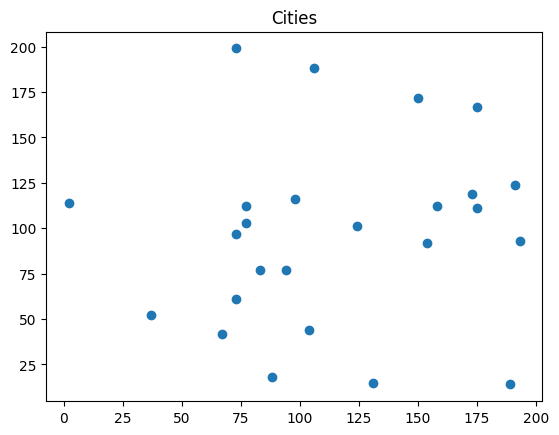

In [ ]:
plot_cities(citylist, "Cities")

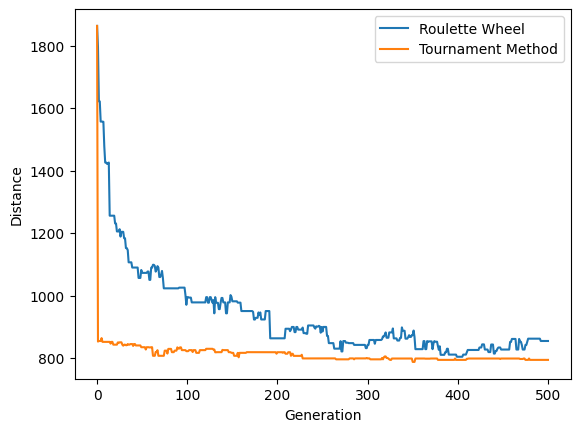

In [23]:
geneticAlgorithmPlot(citylist, size_of_population=100, elite_size=20, mutation_rate=0.01, no_of_generation=500, tournament_size = 3)

# **From the above observations, we can clearly say tournament based method is a better method as compared to roulette wheel method**